In [228]:
import pandas as pd

In [229]:
df = pd.read_pickle("balanced_inputs.pkl")

In [230]:
len(df)

387216

In [231]:
# shuffle the dataframe
df = df.sample(frac = 1, random_state = 1)

In [119]:
N = 5000

In [120]:
#data = df.to_csv("balanced_inputs_lm_recall.csv", sep="\t")

In [121]:
df_short = df[:N]
#tokenizer_bert(x, return_tensors="pt")

In [232]:
df_short = df

In [248]:
inp = df_short["context"].iloc[0]
print(inp)

On the rare occasion Stevens feels the need to correct a player , he does it with positive reinforcement , just at a little louder decibel , according to former assistant coach Matthew Graves . Above all , Stevens wants his players to be confident , not living in fear of being yanked for making a bad play . Externally , Stevens is always calm , but internally he is far from it . I 'm not as calm as everybody thinks , Stevens says . His wife Tracy adds , He s calm and collected , but he s fiercely competitive . He s always thinking about how he can beat you . Former player Joel Cornette says Everyone sees Brad as a level headed , calm and cool coach , but he s about as competitive of a guy as I know . We would get into it constantly , whether playing two on two or arguing about players having better college careers . Stevens spends a lot of time preparing for each game , and always tries to add a few new wrinkles specific to that game 's opponent . Sports Illustrated calls Stevens an ex

In [250]:
df_short["context_length"].iloc[0]

369

In [249]:
a = tokenizer_bert(inp, return_length=True, return_tensor="pt")
print(a)

Keyword arguments {'return_tensor': 'pt'} not recognized.


{'input_ids': [101, 1212, 1103, 4054, 6116, 8437, 5115, 1103, 1444, 1106, 5663, 170, 1591, 117, 1119, 1674, 1122, 1114, 3112, 21293, 1880, 117, 1198, 1120, 170, 1376, 11579, 1260, 6617, 8511, 117, 2452, 1106, 1393, 3109, 2154, 4754, 16494, 119, 12855, 1155, 117, 8437, 3349, 1117, 2139, 1106, 1129, 9588, 117, 1136, 1690, 1107, 2945, 1104, 1217, 10968, 1111, 1543, 170, 2213, 1505, 119, 22841, 1193, 117, 8437, 1110, 1579, 5017, 117, 1133, 19266, 1119, 1110, 1677, 1121, 1122, 119, 146, 112, 182, 1136, 1112, 5017, 1112, 10565, 6191, 117, 8437, 1867, 119, 1230, 1676, 10435, 9807, 117, 1124, 188, 5017, 1105, 4465, 117, 1133, 1119, 188, 17494, 6591, 119, 1124, 188, 1579, 2422, 1164, 1293, 1119, 1169, 3222, 1128, 119, 6963, 1591, 8773, 3291, 12275, 3786, 1867, 6064, 5302, 7796, 1112, 170, 1634, 2917, 117, 5017, 1105, 4348, 2154, 117, 1133, 1119, 188, 1164, 1112, 6591, 1104, 170, 2564, 1112, 146, 1221, 119, 1284, 1156, 1243, 1154, 1122, 7480, 117, 2480, 1773, 1160, 1113, 1160, 1137, 8995, 1164, 

In [219]:
tokenizer.decode(a.input_ids)

'[CLS] It offers a view of the Bintulu oil and gas facilities shortly after nightfall. Bintulu Promenade is a 3 kilometre 2 mi walkway along the Bintulu coastline with the River [SEP]'

In [221]:
len(a.input_ids)

42

In [234]:
df_short["bert_token_length"] = df_short["context"].apply(lambda x: 
                                                          len(tokenizer_bert(x).input_ids))

KeyboardInterrupt: 

In [224]:
df_short = df_short[df_short["bert_token_length"]<512]

In [235]:
df_short.head()

,query,context,label,context_length,valence,arousal,dominance,num_meanings,num_rep,int_tok
2431139,percentage,On the rare occasion Stevens feels the need to...,1,369,0.469,0.400,0.553,2,1,55
599494,broadside,Concentrating guns amidships meant the ship co...,1,283,0.459,0.316,0.462,8,2,270
678885,past,Ms. is currently under display in the Maritime...,1,296,0.490,0.422,0.311,6,1,28
955468,win,Ownership and maintenance of NY 31B 's former ...,1,332,0.927,0.694,0.888,6,2,76
606683,influential,"A lighter alternative to the turret , particul...",1,393,0.899,0.688,0.944,1,1,103


<AxesSubplot:>

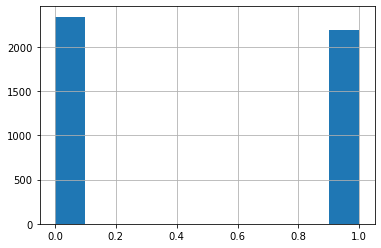

In [226]:
df_short['label'].hist()

In [227]:
len(df_short)

4539

In [124]:
len(df.loc[df['label']==1])

193608

In [125]:
# build model
import os
import torch
from torch import nn
from torch.utils.data import DataLoader

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [190]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.linear = nn.Sequential(
            # 384 is the size of the embedding
            nn.Linear(768, 768)
        )

    def forward(self, x, y):
        #print(x.size())
        x_input = self.linear(x)
        #print(x_input.size())
        #print(y.size())
        op = torch.sum(x_input*y, dim=1)
        #print(op.shape)
        return op

In [191]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
  )
)


In [192]:
import torch.optim as optim

#criterion = nn.functional.binary_cross_entropy()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [236]:
# create a dataset with the dataframe
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

    def __init__(self, dataframe):

        self.context = dataframe.iloc[:,1]
        self.query = dataframe.iloc[:,0]
        self.labels = dataframe.iloc[:, 2]

        #self.x_train=torch.tensor(x,dtype=torch.float32)
        #self.y_train=torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.query)
  
    def __getitem__(self, idx):
        #print(self.query[idx], self.labels[idx])
        return self.context.iloc[idx], self.query.iloc[idx], self.labels.iloc[idx]

ValueError: Sum of input lengths does not equal the length of the input dataset!

In [263]:
complete_loader = DataLoader(data_set,batch_size=1024,shuffle=False) 

In [273]:
def get_tokens(r):
    r_inputs  = tokenizer_bert(r, return_length=True)


    l = r_inputs.length
    #print(l)
    return l

In [274]:
len_tokens = []

for c, q, labels in tqdm(complete_loader):
    len_tokens += get_tokens(c)
  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 379/379 [29:31<00:00,  4.67s/it]


In [277]:
df_short["tokenized_context_length"] = len_tokens

In [278]:
df_short.to_pickle("balanced_inputs_bert_token_len.pkl")

In [279]:
df_short.to_csv("balanced_bert_token_len_lm_recall.csv", sep="\t")

In [276]:
df_short.head()

,query,context,label,context_length,valence,arousal,dominance,num_meanings,num_rep,int_tok,tokenized_context_length
2431139,percentage,On the rare occasion Stevens feels the need to...,1,369,0.469,0.400,0.553,2,1,55,389
599494,broadside,Concentrating guns amidships meant the ship co...,1,283,0.459,0.316,0.462,8,2,270,325
678885,past,Ms. is currently under display in the Maritime...,1,296,0.490,0.422,0.311,6,1,28,352
955468,win,Ownership and maintenance of NY 31B 's former ...,1,332,0.927,0.694,0.888,6,2,76,360
606683,influential,"A lighter alternative to the turret , particul...",1,393,0.899,0.688,0.944,1,1,103,460


In [283]:
len(df_short[df_short["tokenized_context_length"] > 512])

0

In [282]:
df_short = df_short[df_short["tokenized_context_length"] < 512]

In [285]:
df_short.head()

,query,context,label,context_length,valence,arousal,dominance,num_meanings,num_rep,int_tok,tokenized_context_length
2431139,percentage,On the rare occasion Stevens feels the need to...,1,369,0.469,0.400,0.553,2,1,55,389
599494,broadside,Concentrating guns amidships meant the ship co...,1,283,0.459,0.316,0.462,8,2,270,325
678885,past,Ms. is currently under display in the Maritime...,1,296,0.490,0.422,0.311,6,1,28,352
955468,win,Ownership and maintenance of NY 31B 's former ...,1,332,0.927,0.694,0.888,6,2,76,360
606683,influential,"A lighter alternative to the turret , particul...",1,393,0.899,0.688,0.944,1,1,103,460


In [287]:
from torch.utils.data import random_split

data_set = CustomDataset(df_short)

# split the dataset into train(80%), validation(10%), and test(10%)
train_len = int(len(df_short)*0.8)
test_len = int(len(df_short)*0.1)
val_len = len(df_short) - train_len - test_len
train_set, val_set, test_set = random_split(data_set, [train_len, val_len, test_len])


train_loader = DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = DataLoader(test_set,batch_size=128,shuffle=False)
val_loader = DataLoader(val_set,batch_size=128,shuffle=False) 


In [288]:
train_len

280265

In [289]:
test_len

35033

In [290]:
val_len

35034

In [157]:
"""
from sentence_transformers import SentenceTransformer
model_sent_trans = SentenceTransformer('paraphrase-MiniLM-L6-v2')
"""

"\nfrom sentence_transformers import SentenceTransformer\nmodel_sent_trans = SentenceTransformer('paraphrase-MiniLM-L6-v2')\n"

In [291]:
from transformers import BertTokenizer, BertModel, BertTokenizerFast
import torch

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-cased")
model_bert = BertModel.from_pretrained("bert-base-cased").to(device)

for param in model_bert.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [159]:
from tqdm import tqdm

In [160]:
#https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html?highlight=accuracy
import torchmetrics

In [161]:
checkpoint_path = '/data/sherin/checkpoint_lm/chkpt_lm_recall_best.pt.tar'

In [162]:
# function to save checkpoint
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
#https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
def checkpoint_save(state, is_best, filename = '/data/sherin/checkpoint_lm/chkpt_lm_recall_best.pt.tar'):
    if is_best:
        print("saving checkpoint")
        torch.save(state, filename)
    else:
        print("did not improve")

In [198]:
def get_rep(r, is_context):
    r_inputs  = tokenizer_bert(r, return_tensors="pt", truncation=True, padding=True).to(device)
    r_op = model_bert(**r_inputs)
    if is_context:
        #CLS token
        token_id = 0
    else:
        # query token
        token_id = 1
    
    representation = r_op.last_hidden_state[:,token_id,:]
    
    return representation
    

In [ ]:
epoch_loss_list = []
accuracy_list = []
val_loss_list = []
val_acc_list = []
valid_acc_max = 0 

for epoch in range(20):  # loop over the dataset multiple times
    train_count = 0
    model.train()
    epoch_loss = 0.0
    accuracy = 0.0
    
    #for ind in tqdm(range(len(df_short)))
    for c, q, labels in tqdm(train_loader):
        train_count = train_count+1
        #context = torch.tensor(model_sent_trans.encode(list(c))).to(device)
        context = get_rep(c, is_context=True)
        #print(context.size())
        
        #query = torch.tensor(model_sent_trans.encode(list(q))).to(device)
        query = get_rep(q, is_context=False)
        
        target = labels.to(device)
        #label = torch.tensor(labels.float()).to(device)
        label = labels.float().to(device)
        #print(context.size())
        #print(query.size())     
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(context, query)
        #loss = criterion(outputs, labels)
        loss = criterion(outputs, label)
        loss.backward()

        optimizer.step()
        #print(loss.item())
        # print statistics
        #running_loss += loss.item()
        epoch_loss += loss.item()
        accuracy += torchmetrics.functional.accuracy(outputs, target, threshold=0.5).item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #running_loss = 0.0
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    test_count = 0
    for c, q, labels in tqdm(val_loader):
        test_count = test_count + 1
        context = get_rep(c, is_context=True)
        query = get_rep(q, is_context=False)

        target = labels.to(device)
        label = labels.float().to(device)
        
        outputs = model(context, query)
        loss = criterion(outputs, label)
        val_loss += loss.item()
        val_acc += torchmetrics.functional.accuracy(outputs, target, threshold=0.5).item()
        
    accuracy = accuracy / train_count
    epoch_loss = epoch_loss / train_count
    val_loss = val_loss / test_count
    val_acc = val_acc / test_count
    
    if val_acc > valid_acc_max:
        print("saving best model")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
            }, checkpoint_path)
        valid_acc_max = val_acc
    else:
        print("not saving the model")
    
    print(f'[{epoch + 1}, {i + 1:5d}] Training loss: {epoch_loss:.3f} Training accuracy : {accuracy:.3f}')
    print(f'[{epoch + 1}, {i + 1:5d}] Validation loss: {val_loss:.3f} Validation accuracy : {val_acc:.3f}')
    epoch_loss_list.append(epoch_loss)
    accuracy_list.append(accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

print('Finished Training')

 40%|█████████████████████████████████████████████████████                                                                                | 874/2190 [13:25<20:12,  1.09it/s]

In [295]:
print("p")

p


In [301]:
# # https://pytorch.org/tutorials/beginner/saving_loading_models.html
# for inference - load checkpointed model

model = NeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
PATH = checkpoint_path
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# inferece
model.eval()

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
  )
)

In [960]:
val_acc = val_acc_list[epoch]
print(val_acc)

0.8190408303354778


In [307]:
test_count = 0
output_logits = []
for c, q, labels in tqdm(test_loader):
    context = get_rep(c, is_context=True)
    query = get_rep(q, is_context=False)

    target = labels.to(device)
    label = labels.float().to(device)
        
    outputs = model(context, query).detach().cpu().numpy()
    output_logits.append(outputs)


    

100%|█████████████████████████████████████████| 274/274 [04:17<00:00,  1.06it/s]


In [311]:
test_output_logits = np.hstack(output_logits)

In [317]:
df_test = df_short.iloc[test_loader.dataset.indices]

In [318]:
len(df_test)

35033

In [319]:
df_val = df_short.iloc[val_loader.dataset.indices]

In [320]:
df_train = df_short.iloc[train_loader.dataset.indices]

In [321]:
df_train.to_pickle("df_train.pkl")
df_val.to_pickle("df_val.pkl")
df_test.to_pickle("df_test.pkl")

In [322]:
df_test["bert_pred"] = test_output_logits

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [325]:
df_test["bert_pred"] = torch.sigmoid(torch.tensor(test_output_logits)).cpu().numpy()

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [328]:
df_test["bert_pred_label"] = 1.0 * (df_test["bert_pred"] > 0.5)

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [333]:
df_test.head()

,query,context,label,context_length,valence,arousal,dominance,num_meanings,num_rep,int_tok,tokenized_context_length,bert_pred,bert_pred_label
2926527,belief,Vitellius began his reign with a large funeral...,1,47,0.896,0.375,0.656,2,1,18,53,0.966313,1.0
3480004,first,In 2015 UPM was ranked 41st in the UI World Un...,0,98,0.625,0.500,0.788,16,0,-1,104,0.010598,0.0
3437764,capacity,"Currently , 45 of Malaysian natural gas is fou...",1,132,0.719,0.411,0.806,9,1,61,162,0.769480,1.0
3394750,small,"However , the airstrip was heavily bombed by A...",1,409,0.542,0.205,0.120,13,1,209,478,0.999919,1.0
629147,navy,Though the ships were laid down in 1873 their ...,1,44,0.531,0.760,0.764,3,1,23,46,0.045550,0.0


In [335]:
def get_conf(l, b):
    if l == 1:
        conf = b
    else:
        conf = 1-b
    
    return conf

In [338]:
df_test["bert_conf_of_correct_class"] = df_test.apply(lambda x: get_conf(x['label'], x['bert_pred']), axis=1)

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [453]:
df_test["success"] = 1.0 * (df_test["bert_pred_label"] == df_test["label"])

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


query
abandoned    0.692308
able         0.705882
abreast      1.000000
absent       0.833333
academic     0.800000
               ...   
year         0.806931
years        0.785185
yield        0.000000
youth        1.000000
zone         0.812500
Length: 1954, dtype: float64

In [366]:
df_test["bert_pred_label"] = 1.0 * (df_test["bert_pred"] > 0.5)

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [371]:
df_test["valence"] = pd.to_numeric(df_test["valence"])
df_test["arousal"] = pd.to_numeric(df_test["arousal"])
df_test["dominance"] = pd.to_numeric(df_test["dominance"])

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [357]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 292 kB 4.3 MB/s eta 0:00:01


In [358]:
import seaborn as sns

In [374]:
# histogram
true_label = df_test['label'].values
bert_label = df_test['bert_pred_label'].values
valence = df_test['valence'].values
arousal = df_test['arousal'].values
dominance = df_test['dominance'].values

In [403]:
bert_pos_conf = df_test['bert_pred'].values

Text(0, 0.5, 'number of samples')

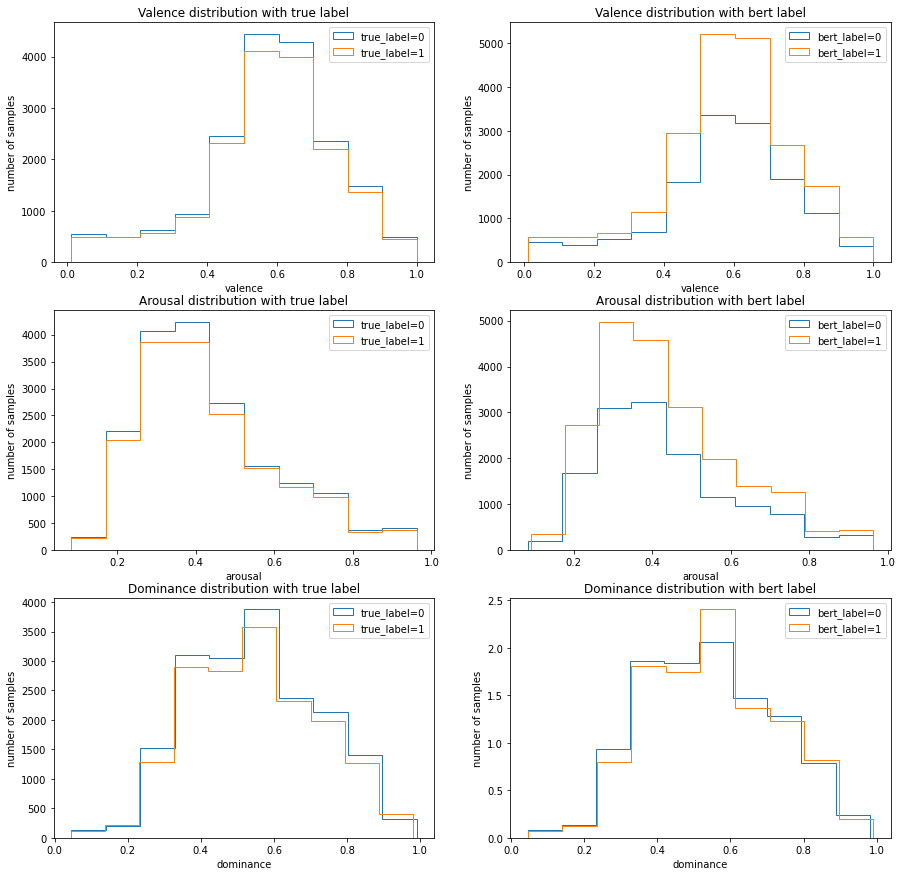

In [525]:
# plots for valence, arousal, and dominance
fig, axs = plt.subplots(3, 2, figsize=[15,15])
axs[0, 0].hist(valence[true_label==0], label='true_label=0', histtype='step')
axs[0, 0].hist(valence[true_label==1], label='true_label=1', histtype='step')
axs[0, 0].legend()
axs[0, 0].set_title('Valence distribution with true label')
axs[0, 0].set_xlabel('valence')
axs[0, 0].set_ylabel('number of samples')

axs[0, 1].hist(valence[bert_label==0], label='bert_label=0', histtype='step')
axs[0, 1].hist(valence[bert_label==1], label='bert_label=1', histtype='step')
axs[0, 1].legend()
axs[0, 1].set_title('Valence distribution with bert label')
axs[0, 1].set_xlabel('valence')
axs[0, 1].set_ylabel('number of samples')

axs[1, 0].hist(arousal[true_label==0], label='true_label=0', histtype='step')
axs[1, 0].hist(arousal[true_label==1], label='true_label=1', histtype='step')
axs[1, 0].legend()
axs[1, 0].set_title('Arousal distribution with true label')
axs[1, 0].set_xlabel('arousal')
axs[1, 0].set_ylabel('number of samples')

axs[1, 1].hist(arousal[bert_label==0], label='bert_label=0', histtype='step')
axs[1, 1].hist(arousal[bert_label==1], label='bert_label=1', histtype='step')
axs[1, 1].legend()
axs[1, 1].set_title('Arousal distribution with bert label')
axs[1, 1].set_xlabel('arousal')
axs[1, 1].set_ylabel('number of samples')

axs[2, 0].hist(dominance[true_label==0], label='true_label=0', histtype='step')
axs[2, 0].hist(dominance[true_label==1], label='true_label=1', histtype='step')
axs[2, 0].legend()
axs[2, 0].set_title('Dominance distribution with true label')
axs[2, 0].set_xlabel('dominance')
axs[2, 0].set_ylabel('number of samples')

axs[2, 1].hist(dominance[bert_label==0], density=True, label='bert_label=0', histtype='step')
axs[2, 1].hist(dominance[bert_label==1], density=True, label='bert_label=1', histtype='step')
axs[2, 1].legend()
axs[2, 1].set_title('Dominance distribution with bert label')
axs[2, 1].set_xlabel('dominance')
axs[2, 1].set_ylabel('number of samples')

<AxesSubplot:>

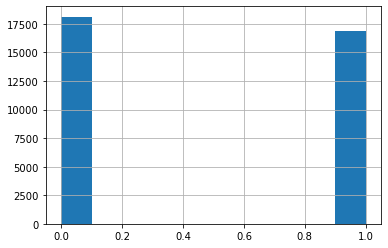

In [387]:
df_test['label'].hist()

<AxesSubplot:>

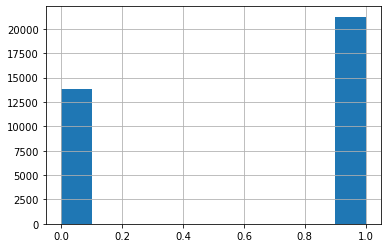

In [388]:
df_test['bert_pred_label'].hist()

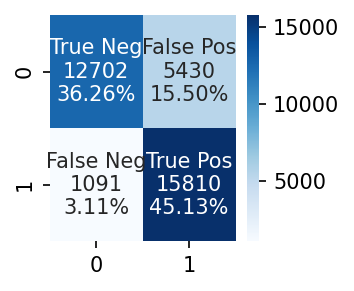

In [803]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(2, 2), dpi=150)
cf_matrix = confusion_matrix(df_test['label'], df_test['bert_pred_label'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('confusion_matrix.png')


In [426]:
def plot_attribute_bins(prop_values, prop_name):
    # prop_values = valence, arousal, or dominance
    # based on uq360 ece; same for vad
    bins_edges = np.histogram_bin_edges([], bins=10, range=(0.0, 1.0))
    non_boundary_bin_edges = bins_edges[1:-1]
    bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
    
    sample_bin_ids = np.digitize(prop_values, non_boundary_bin_edges)
    num_samples_in_bins = np.zeros(10)
    confidences_in_bins = np.zeros(10)
    true_confidences_in_bins = np.zeros(10)
    
    
    # bert labels
    for bin in range(10):
        num_samples_in_bins[bin] = len(prop_values[sample_bin_ids == bin])
        if num_samples_in_bins[bin] > 0:
            confidences_in_bins[bin] = np.sum(bert_label[sample_bin_ids == bin]) / num_samples_in_bins[bin]
            
            
    # true labels
    for bin in range(10):
        num_samples_in_bins[bin] = len(prop_values[sample_bin_ids == bin])
        if num_samples_in_bins[bin] > 0:
            true_confidences_in_bins[bin] = np.sum(true_label[sample_bin_ids == bin]) / num_samples_in_bins[bin]
    
    plt.plot(bin_centers, true_confidences_in_bins, 'o-',label='true')
    plt.plot(bin_centers, confidences_in_bins, 's-', label='bert')
    plt.legend()
    plt.xlabel(prop_name)
    plt.ylabel('$P_{bert}(y=1)$')

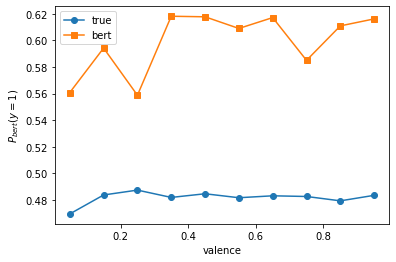

In [427]:
plot_attribute_bins(valence, 'valence')

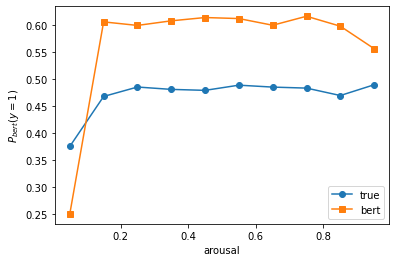

In [428]:
plot_attribute_bins(arousal, 'arousal')

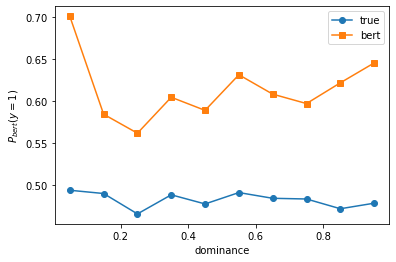

In [429]:
plot_attribute_bins(dominance, 'dominance')

In [456]:
query_success_rate = df_test.groupby(["query"], group_keys=False).apply(lambda x: x['success'].mean())

In [465]:
less_confident = query_success_rate.sort_values()[0:30]
more_confident = query_success_rate.sort_values()[-30:]

In [466]:
print(less_confident)

query
notably         0.0
outcome         0.0
improbable      0.0
petition        0.0
announcement    0.0
powerful        0.0
predominant     0.0
aged            0.0
projectile      0.0
prosecution     0.0
publication     0.0
response        0.0
origin          0.0
freedom         0.0
craze           0.0
terminus        0.0
rounded         0.0
fossil          0.0
flag            0.0
contribution    0.0
ensemble        0.0
synthetic       0.0
extensive       0.0
expected        0.0
strategic       0.0
ropes           0.0
adopt           0.0
destroy         0.0
clone           0.0
denied          0.0
dtype: float64


In [467]:
print(more_confident)

query
recruit        1.0
keen           1.0
convoy         1.0
reflect        1.0
rarely         1.0
fall           1.0
rap            1.0
rally          1.0
feature        1.0
fears          1.0
protected      1.0
favorite       1.0
favorable      1.0
fashionable    1.0
psychic        1.0
chariot        1.0
publish        1.0
property       1.0
publishing     1.0
barrier        1.0
farther        1.0
familiar       1.0
race           1.0
radar          1.0
radical        1.0
kilogram       1.0
railway        1.0
raised         1.0
push           1.0
expanded       1.0
dtype: float64


In [468]:
acc_context_length = df_test.groupby(["context_length"], group_keys=False).apply(lambda x: x['success'].mean())

In [486]:
num_meanings = df_test.groupby(["num_meanings"], group_keys=False).apply(lambda x: x['success'].mean())

In [487]:
num_rep = df_test.groupby(["num_rep"], group_keys=False).apply(lambda x: x['success'].mean())

In [488]:
int_tok = df_test.groupby(["int_tok"], group_keys=False).apply(lambda x: x['success'].mean())

In [471]:
acc_context_length_std = df_test.groupby(["context_length"], group_keys=False).apply(lambda x: x['success'].std())

In [469]:
acc_context_length

context_length
1      1.000000
2      0.967742
3      0.967742
4      0.983333
5      0.983607
         ...   
492    1.000000
493    1.000000
494    0.000000
495    1.000000
500    1.000000
Length: 496, dtype: float64

Text(0, 0.5, 'accuracy')

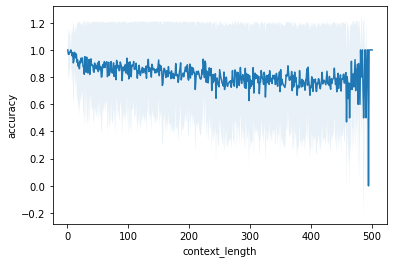

In [474]:
plt.plot(acc_context_length.index, acc_context_length)
plt.fill_between(acc_context_length.index,
                 acc_context_length-acc_context_length_std,
                 acc_context_length+acc_context_length_std, alpha=0.1)
plt.xlabel('context_length')
plt.ylabel('accuracy')

In [516]:
def plot_acc(prop, labelx):
    num_bins = 20
    num_samples_in_bins = np.zeros(num_bins)
    bins_edges = np.histogram_bin_edges([], bins=num_bins, range=(min(prop.index), max(prop.index)))
    non_boundary_bin_edges = bins_edges[1:-1]
    bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
    sample_bin_ids = np.digitize(prop.index, non_boundary_bin_edges)
    num_samples_in_bins = np.zeros(num_bins)
    acc_in_bins = np.zeros(num_bins)
    acc_in_bins_std = np.zeros(num_bins)
    
    for bin in range(num_bins):
        num_samples_in_bins[bin] = len(prop[sample_bin_ids == bin])
        if num_samples_in_bins[bin] > 0:
            acc_in_bins[bin] = np.sum(prop[sample_bin_ids == bin]) / num_samples_in_bins[bin]
            acc_in_bins_std[bin] = np.std(prop[sample_bin_ids == bin])
    
    plt.plot(bin_centers, acc_in_bins, 's--')
    plt.fill_between(bin_centers,
                     acc_in_bins-acc_in_bins_std,
                     acc_in_bins+acc_in_bins_std,
                     alpha=0.1
                    )
    #plt.plot(bin_centers, 1.0* num_samples_in_bins/np.sum(num_samples_in_bins), '^--')
    #print(1.0* num_samples_in_bins/np.sum(num_samples_in_bins))
    plt.xlabel(labelx)
    plt.ylabel('accuracy')
    

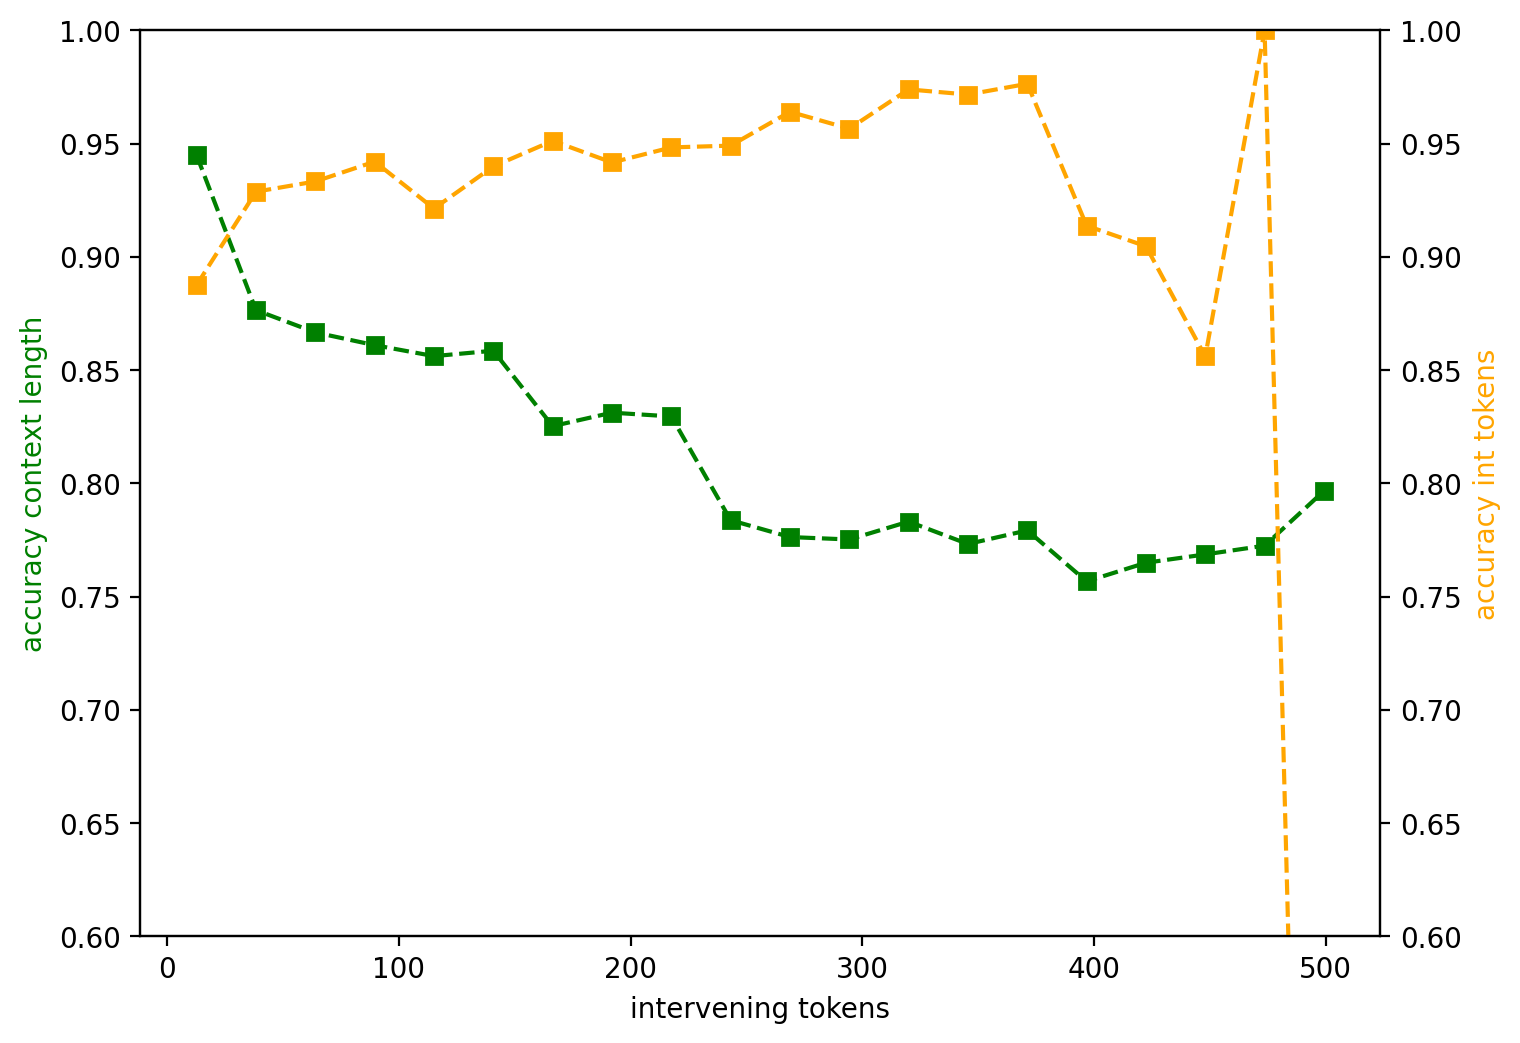

In [824]:
# merge the plots of both intervening tokens and context length

fig = plt.figure(figsize=(8, 6), dpi=200)
    
num_bins = 20
num_samples_in_bins = np.zeros(num_bins)
#bins_edges = np.histogram_bin_edges([], bins=num_bins, range=(min(acc_context_length.index), max(acc_context_length.index)))
bins_edges = np.histogram_bin_edges([], bins=num_bins, range=(0, 512))
non_boundary_bin_edges = bins_edges[1:-1]
bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
sample_bin_ids_c = np.digitize(acc_context_length.index, non_boundary_bin_edges)
sample_bin_ids_i = np.digitize(int_tok.index, non_boundary_bin_edges)
num_samples_in_bins_c = np.zeros(num_bins)
num_samples_in_bins_i = np.zeros(num_bins)
acc_in_bins_c = np.zeros(num_bins)
acc_in_bins_std_c = np.zeros(num_bins)
acc_in_bins_i = np.zeros(num_bins)
acc_in_bins_std_i = np.zeros(num_bins)
    
for bin in range(num_bins):
    num_samples_in_bins_c[bin] = len(acc_context_length[sample_bin_ids_c == bin])
    if num_samples_in_bins_c[bin] > 0:
        acc_in_bins_c[bin] = np.sum(acc_context_length[sample_bin_ids_c == bin]) / num_samples_in_bins_c[bin]
        acc_in_bins_std_c[bin] = np.std(acc_context_length[sample_bin_ids_c == bin])
        
for bin in range(num_bins):
    num_samples_in_bins_i[bin] = len(int_tok[sample_bin_ids_i == bin])
    if num_samples_in_bins_i[bin] > 0:
        acc_in_bins_i[bin] = np.sum(int_tok[sample_bin_ids_i == bin]) / num_samples_in_bins_i[bin]
        acc_in_bins_std_i[bin] = np.std(int_tok[sample_bin_ids_i == bin])
    
ax = fig.add_subplot(111)    
ax.plot(bin_centers, acc_in_bins_c, 's--', color='green', label='context length')    
#ax.fill_between(bin_centers,
#                     acc_in_bins_c-acc_in_bins_std_c,
#                     acc_in_bins_c+acc_in_bins_std_c,
#                     alpha=0.1
#                    )    

ax2 = ax.twinx()
ax2.plot(bin_centers, acc_in_bins_i, 's--', color='orange', label='intervening tokens')    
#ax2.fill_between(bin_centers,
#                     acc_in_bins_i-acc_in_bins_std_i,
#                     acc_in_bins_i+acc_in_bins_std_i,
#                     alpha=0.1
#                    )    

ax.set_xlabel('intervening tokens')
ax.set_ylabel("accuracy context length", color='green')
ax2.set_ylabel("accuracy int tokens", color='orange')
ax.set_ylim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)

#plt.show()
plt.savefig('bert_nl_context_len_int_tok.png')

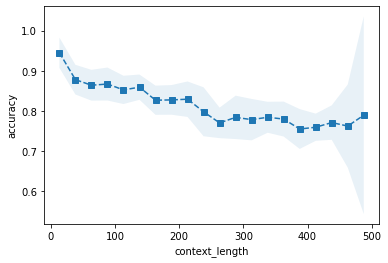

In [517]:
plot_acc(acc_context_length, 'context_length')

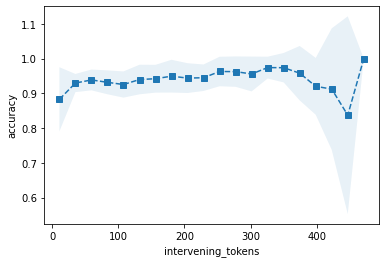

In [518]:
plot_acc(int_tok, 'intervening_tokens')

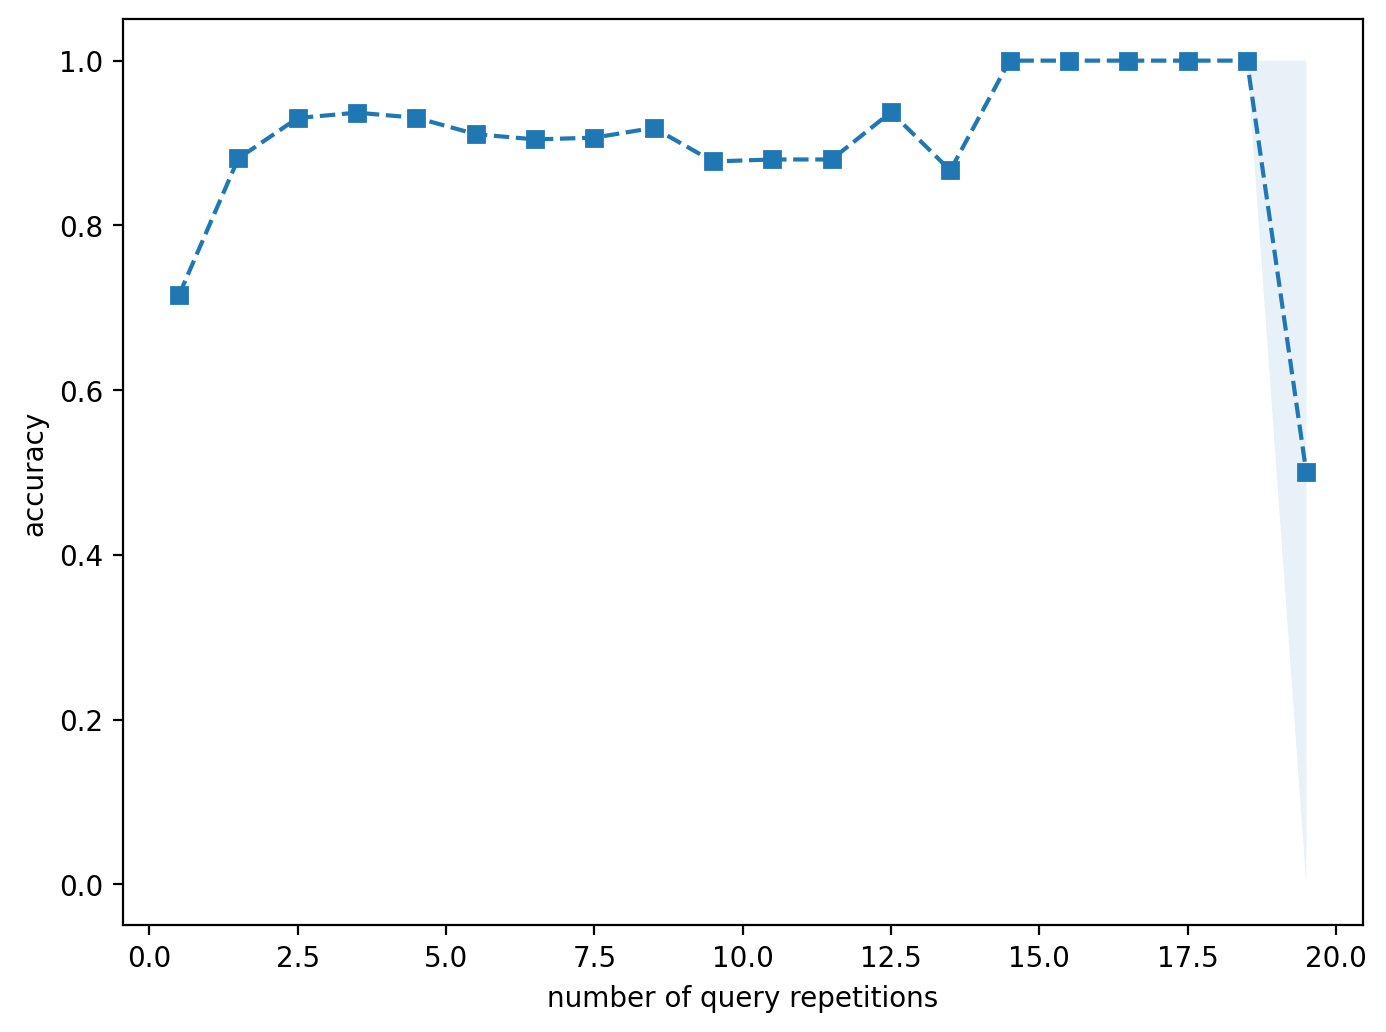

In [826]:
fig = plt.figure(figsize=(8, 6), dpi=200)
plot_acc(num_rep, 'number of query repetitions')
plt.savefig('bert_num_query_rep.png')

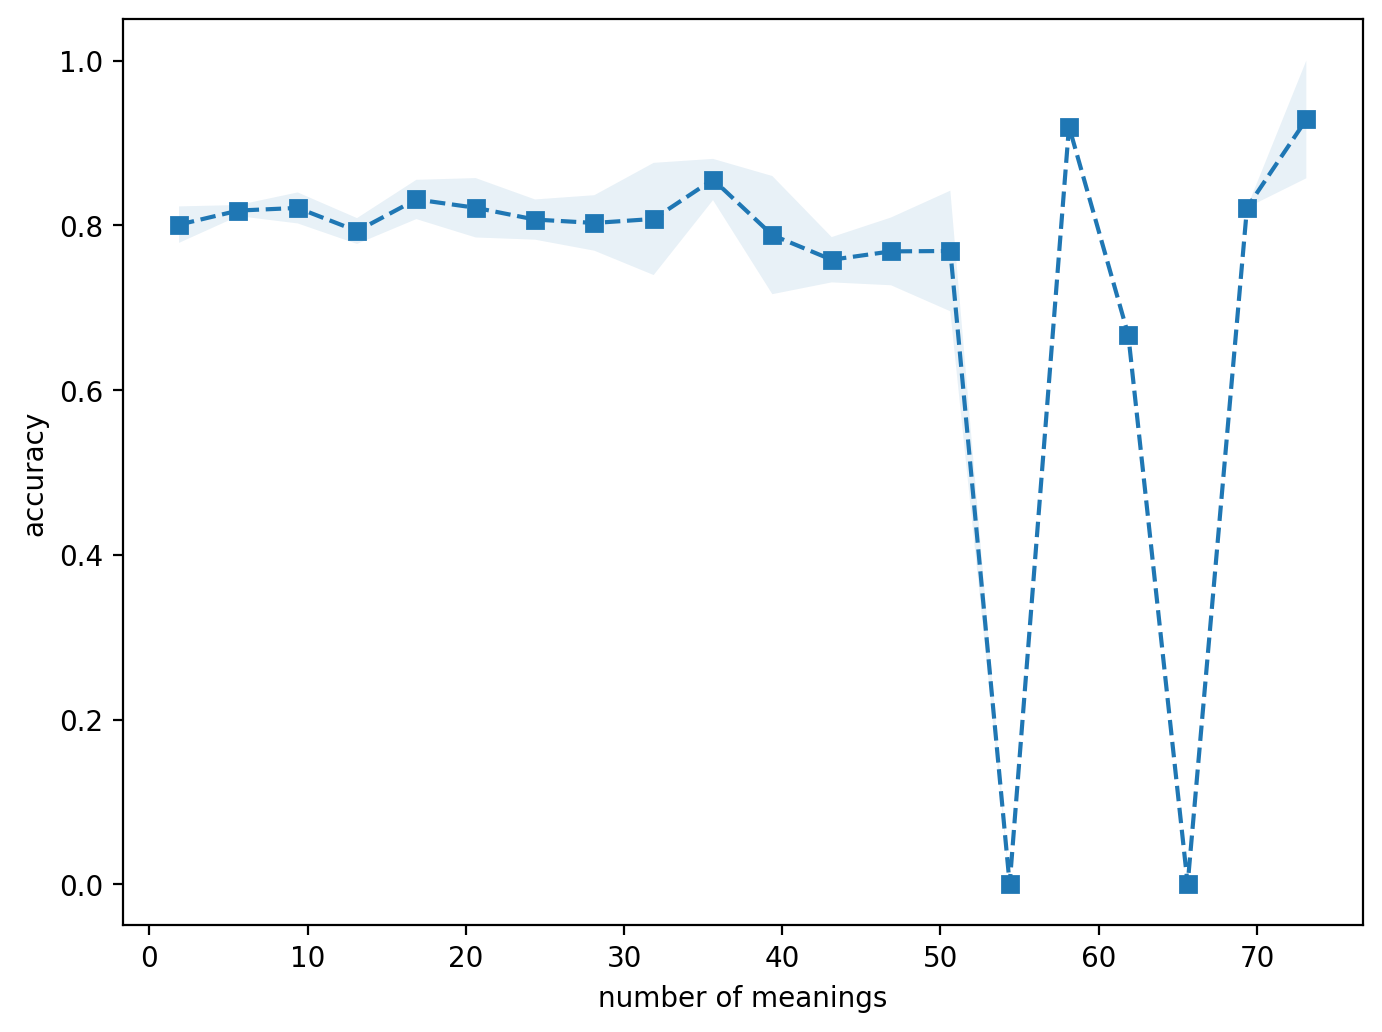

In [827]:
fig = plt.figure(figsize=(8, 6), dpi=200)
plot_acc(num_meanings, 'number of meanings')
plt.savefig('bert_num_meanings.png')

In [519]:
df_test['success'].mean()

0.8138612165672366

In [526]:
len(df_test)

35033

In [524]:
val_acc_list[epoch]

0.8190408303354778

In [523]:
accuracy_list[epoch]

0.8265329838343407

In [534]:
with open ('bias-lexicon.txt') as f:
    bias_lemmas = [line.strip('\n') for line in f]

In [539]:
# check if any of the query lemmas are in the bias_lemmas list
query_list = df_test['query'].to_list()

In [540]:
# get the lemmas of this list and convert it into dataframe and store it back in df_test
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

df_test["query_lemma"] = [lemmatizer.lemmatize(w) for w in query_list]

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [556]:
len(acc_bias_words)

323

In [553]:
less_confident_bias = acc_bias_words.sort_values()[0:30]
more_confident_bias = acc_bias_words.sort_values()[-30:]

In [554]:
less_confident_bias

query
account        0.000000
instance       0.000000
powerful       0.000000
response       0.000000
freedom        0.000000
defend         0.000000
opposition     0.250000
crime          0.333333
controversy    0.333333
common         0.333333
keep           0.333333
launch         0.444444
policy         0.444444
defense        0.473684
exile          0.500000
hold           0.500000
king           0.500000
minority       0.500000
civilian       0.500000
personal       0.500000
possibility    0.500000
presents       0.500000
reputation     0.500000
sexual         0.500000
threat         0.500000
traditional    0.500000
vote           0.500000
widely         0.500000
kingdom        0.500000
calls          0.500000
dtype: float64

In [555]:
more_confident_bias

query
say             1.0
riot            1.0
allow           1.0
regime          1.0
reason          1.0
radical         1.0
race            1.0
promote         1.0
print           1.0
present         1.0
positive        1.0
political       1.0
persons         1.0
serve           1.0
attempt         1.0
participate     1.0
author          1.0
occupation      1.0
neighborhood    1.0
need            1.0
movement        1.0
member          1.0
means           1.0
mean            1.0
maintain        1.0
lawyer          1.0
lands           1.0
lack            1.0
parts           1.0
monk            1.0
dtype: float64

In [ ]:
# get the pos tag for query lemma
# https://www.nltk.org/api/nltk.tag.html#nltk.tag.pos_tag
# different pos - https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# some explanation - https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
#query_pos = nltk.tag.pos_tag([[k] for k in df_test["query"].to_list()])

In [928]:
query_pos = []
for k in df_test["query_lemma"].to_list():
    query_pos.append(nltk.tag.pos_tag([k])[0][1])

In [903]:
len(df_test["query_lemma"])

35033

In [930]:
df_test['query_pos'] = query_pos #list(list(zip(*query_pos))[1])

In [940]:
bias_pos_mean = df_bias.groupby(["query_pos"], group_keys=False).apply(lambda x: x['success'].mean())
bias_pos_hist = df_bias.groupby(["query_pos"], group_keys=False).apply(lambda x: len(x['success']))

In [941]:
acc_bias_words = df_bias.groupby(["query"], group_keys=False).apply(lambda x: x['success'].mean())

In [968]:
from matplotlib import rc
rc('mathtext', default='regular')

def pos_hist_plot(data_axes1, data_axes2, x, tt, xlb, xticks=None, yrange_acc=(0,1)):
    fig = plt.figure(figsize=(8, 6), dpi=100)

    ax = fig.add_subplot(111)
    ax.plot(x, data_axes1, 's--', color='green', label='accuracy')
    ax2 = ax.twinx()
    ax2.bar(x, data_axes2, color='orange', alpha=0.3, label='N')
    #plt.title(tt,
    #          fontweight="bold")

    #ax.legend(loc=0)
    #ax2.legend(loc=0)

    #ax.grid()

    ax.set_xlabel(xlb)
    ax.set_ylabel("accuracy", color='green')

    ax2.set_ylabel("number of samples (N)", color='orange')
    #ax2.set_ylim(0, max(bias_pos_hist.values)+2)
    #ax2.set_yscale('log')
    ax.set_ylim(yrange_acc[0], yrange_acc[1])

    if xticks is not None:
        ax.set_xticklabels(xticks, rotation=45)
        #ax.ticklabel_format(style='sci', scilimits=[-3, 3], axis='x')
    else:
        ax.set_xticklabels(x, rotation=45)
        

    #plt.show()

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

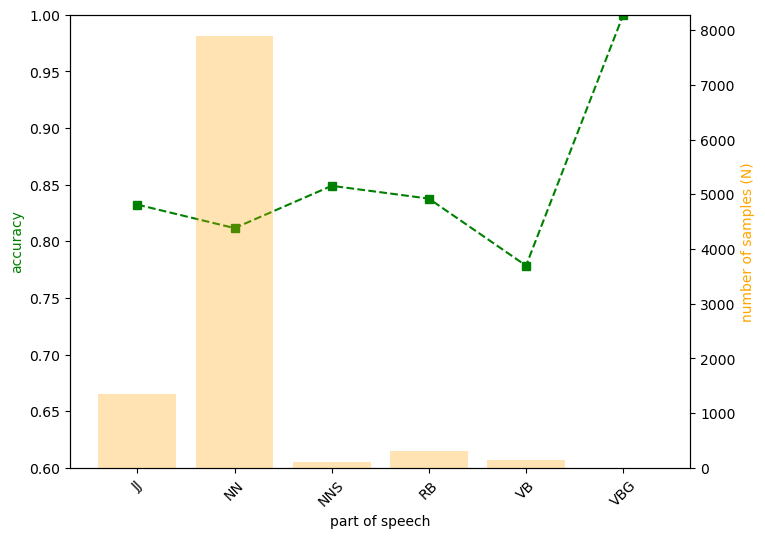

In [969]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(bias_pos_mean.values, bias_pos_hist.values, bias_pos_mean.index, 
              'performance of bias words based on part of speech', "part of speech", yrange_acc=(0.6, 1))
plt.savefig('bert_bias_pos.png')

In [956]:
len(df_bias[df_bias['query_pos']=='NN'])

7887

In [955]:
len(df_test[df_test['query_pos']=='NN'])

21608

In [938]:
pos_mean = df_test.groupby(["query_pos"], group_keys=False).apply(lambda x: x['success'].mean())
pos_hist = df_test.groupby(["query_pos"], group_keys=False).apply(lambda x: len(x['success']))

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

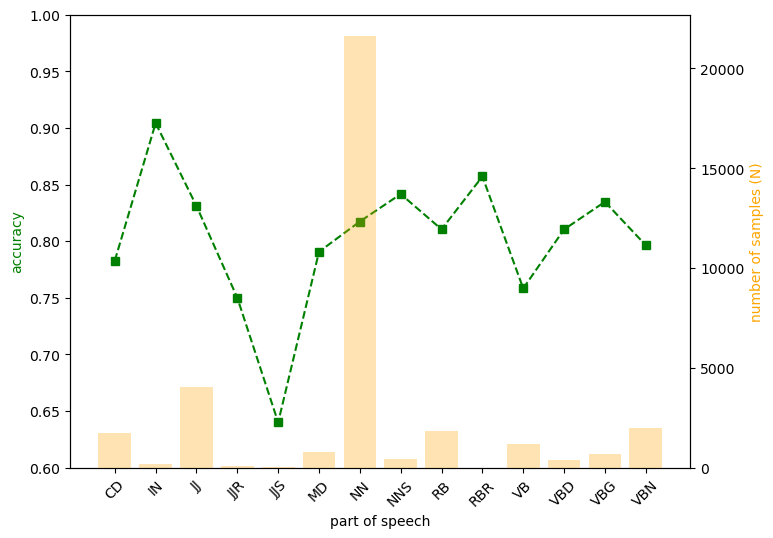

In [971]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(pos_mean.values, pos_hist.values, pos_mean.index, 
              'performance of words based on part of speech', "part of speech", yrange_acc=(0.6, 1))
plt.savefig('bert_pos.png')

In [720]:
# unigram frequency in english language
# https://www.kaggle.com/datasets/rtatman/english-word-frequency?resource=download
word_freq = pd.read_csv("unigram_freq.csv")

In [722]:
# get the query lemma word frequency and add it to the test dataset
df_test = pd.merge(df_test, word_freq, how='left', left_on = 'query_lemma', right_on = "word")
df_test = df_test.drop(columns = ["word"])

In [724]:
df_test['count'].isna().sum()

0

In [861]:
def digitize_bin_variable(var, num_bins):
    num_samples_in_bins = np.zeros(num_bins)
    bins_edges = np.histogram_bin_edges([], bins=num_bins, range=(min(var), max(var)))
    non_boundary_bin_edges = bins_edges[1:-1]
    bin_centers = (bins_edges[1:] + bins_edges[:-1])/2
    sample_bin_ids = np.digitize(var, non_boundary_bin_edges)
    # return the bin each sample belongs to
    return sample_bin_ids, bin_centers

In [841]:
df_test['count_bin_id'], bin_centers = digitize_bin_variable(df_test['count'], 20)

In [842]:
count_mean = df_test.groupby(['count_bin_id'], group_keys=False).apply(lambda x: x['success'].mean())
count_hist = df_test.groupby(['count_bin_id'], group_keys=False).apply(lambda x: len(x['success']))

In [844]:
count_mean_filled = np.zeros_like(bin_centers)
count_mean_filled[count_mean.index] = count_mean.values

In [845]:
count_hist_filled = np.zeros_like(bin_centers)
count_hist_filled[count_hist.index] = count_hist.values

In [775]:
bin_centers

array([6.00704098e+07, 1.80001371e+08, 2.99932333e+08, 4.19863295e+08,
       5.39794256e+08, 6.59725218e+08, 7.79656180e+08, 8.99587141e+08,
       1.01951810e+09, 1.13944906e+09, 1.25938003e+09, 1.37931099e+09,
       1.49924195e+09, 1.61917291e+09, 1.73910387e+09, 1.85903483e+09,
       1.97896580e+09, 2.09889676e+09, 2.21882772e+09, 2.33875868e+09])

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

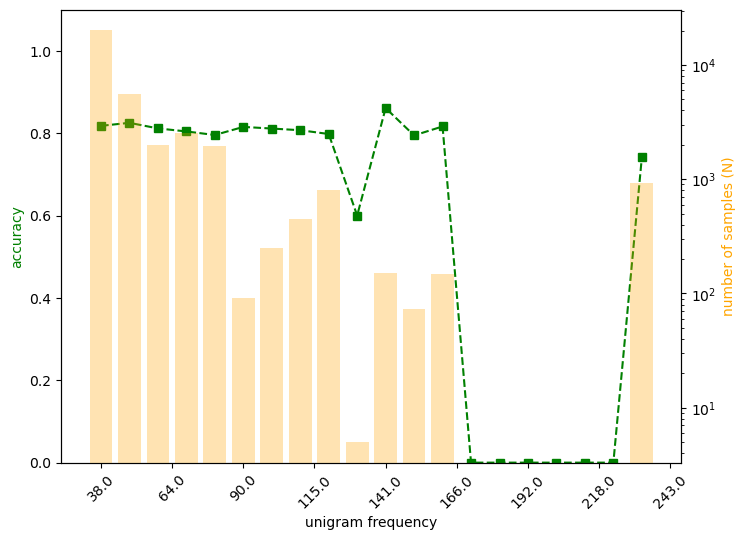

In [846]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(count_mean_filled, count_hist_filled, range(20),  
              'performance of words based on unigram frequency', 'unigram frequency', xticks=np.round(bin_centers))
plt.savefig('bert_unigram.png')

In [862]:
# plot the valence, arousal, and dominance accuracy and histogram
df_test['valence_id'], bin_centers_valence = digitize_bin_variable(df_test['valence'], 10)
df_test['arousal_id'], bin_centers_arousal = digitize_bin_variable(df_test['arousal'], 10)
df_test['dominance_id'], bin_centers_dominance = digitize_bin_variable(df_test['dominance'], 10)

In [863]:
valence_mean = df_test.groupby(['valence_id'], group_keys=False).apply(lambda x: x['success'].mean())
valence_hist = df_test.groupby(['valence_id'], group_keys=False).apply(lambda x: len(x['success']))

arousal_mean = df_test.groupby(['arousal_id'], group_keys=False).apply(lambda x: x['success'].mean())
arousal_hist = df_test.groupby(['arousal_id'], group_keys=False).apply(lambda x: len(x['success']))

dominance_mean = df_test.groupby(['dominance_id'], group_keys=False).apply(lambda x: x['success'].mean())
dominance_hist = df_test.groupby(['dominance_id'], group_keys=False).apply(lambda x: len(x['success']))

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

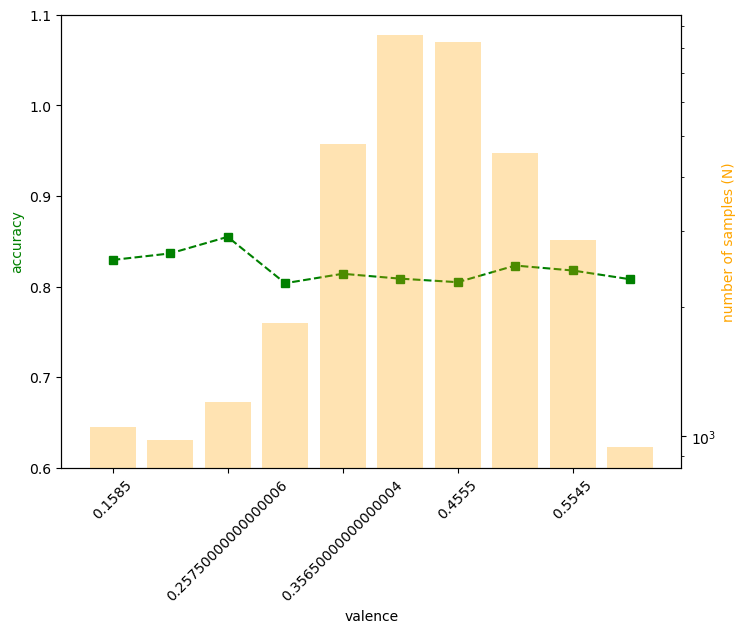

In [882]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(valence_mean, valence_hist, range(10),  
              'performance of words based on valence', 'valence', xticks=bin_centers_valence, yrange_acc=(0.6, 1.1))
plt.savefig('bert_valence.png')

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

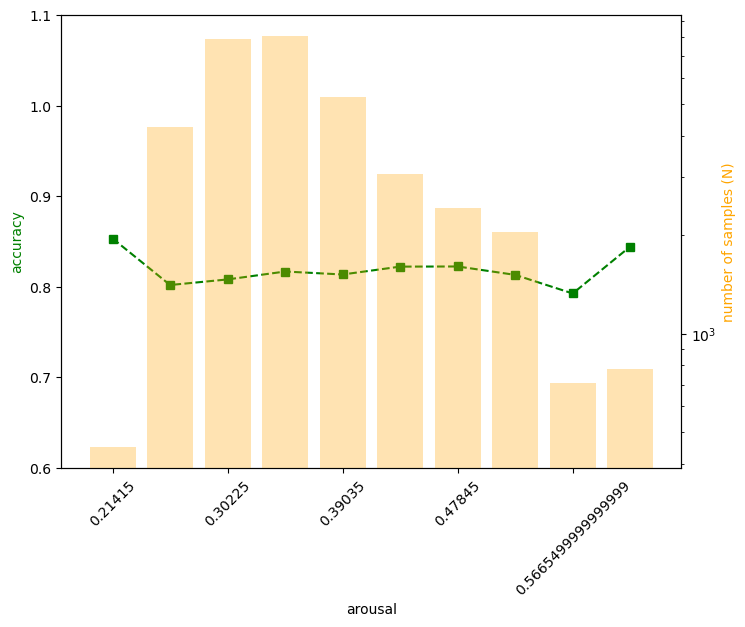

In [884]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(arousal_mean, arousal_hist, range(10),  
              'performance of words based on arousal', 'arousal', xticks=bin_centers_arousal, yrange_acc=(0.6, 1.1))
plt.savefig('bert_arousal.png')

/opt/conda/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1600x1200 with 0 Axes>

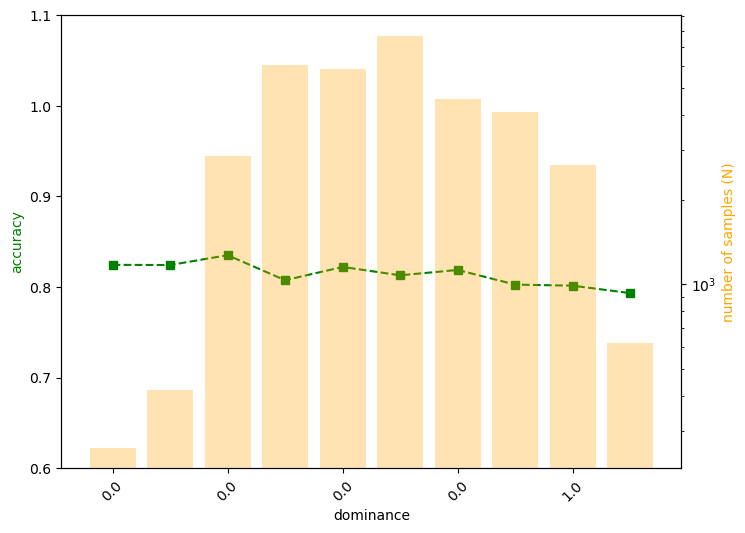

In [887]:
fig = plt.figure(figsize=(8, 6), dpi=200)
pos_hist_plot(dominance_mean, dominance_hist, range(10),  
              'performance of words based on dominance', 'dominance', xticks=np.round(bin_centers_dominance), yrange_acc=(0.6, 1.1))
plt.savefig('bert_dominance.png')

In [888]:
# save df_test to do the mathematical modelling
df_test.to_pickle("test_df.pkl")

In [ ]:
"""
def save_plot(dataset, fair_metric, for_plot_methods, save=True, ylim=[0.0, 0.30]):
    #import seaborn as sb
    #sb.set_context("paper")
    #plt.style.use('presentation.mplstyle')
    
    plt.rcParams.update({'font.size': 20, 'text.color': 'black', 'axes.labelcolor': 'black'})
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for idx, method in enumerate(methods):
        if method in for_plot_methods:
            name = method
            if "IJ" in name:
                name = name.split('IJ')[0]+"-IJ"
            if "mixup" in name:
                name = "FairMixup"+name.split('mixup')[1]
            if "hgr" in name:
                name = "HGR"+name.split('hgr')[1]
                              
            print(results[dataset][fair_metric][method][fair_metric])
            print(results[dataset][fair_metric][method]["acc"])
            if name not in ["ERM", "Fair-IJ"]:
                alpha=1.0
            else:
                alpha=1.0
            plt.plot(
                results[dataset][fair_metric][method][fair_metric],
                results[dataset][fair_metric][method]["acc"],
                markers[idx],
                markersize=20 if name in ["Fair-IJ", "ERM"] else 10,
                linewidth=2,
                linestyle=linestyles[idx],
                label=name,
                color=colors[idx],
                alpha = alpha
            )
    plt.grid(linestyle='--', color='gray')
    if fair_metric == "DEO":
        fair_metric_name = "EQOPP"
    else:
        fair_metric_name = fair_metric
    plt.xlabel("$\Delta$"+fair_metric_name)
    plt.ylabel("Error rate")
    plt.ylim(ylim)
    plt.title(dataset+"-"+fair_metric_name)
    plt.legend(loc=1)
    if save:
        fig.savefig('{}_{}.jpg'.format(dataset, fair_metric),
                       format='jpeg',
                       dpi=100,
                       bbox_inches='tight')
    plt.show()
methods = ["ERM", "mixup", "hgr", "FST", "HPS",
           "mixupIJ",  "hgrIJ", "FSTIJ", "HPSIJ", "FairIJ"]
markers = ['d', 'o', '<', '^', 's',
           'o', '<', '^', '>', 'P',]
colors = ['black','gray', 'cornflowerblue', 'indianred', 'orange', 
          'gray', 'cornflowerblue', 'indianred', 'orange',  'green']
linestyles = ['solid', 'dashed', 'dashed', 'dashed', 'solid', 
          'solid', 'solid', 'solid', 'solid',  'solid']
plt.style.use('ggplot')
"""

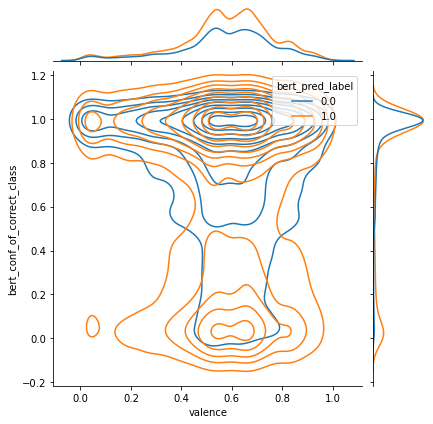

In [367]:
sns.jointplot(data=df_test, x="valence", y="bert_conf_of_correct_class", hue="bert_pred_label", kind="kde")

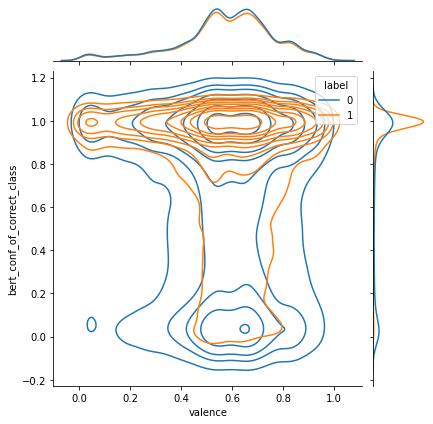

In [368]:
sns.jointplot(data=df_test, x="valence", y="bert_conf_of_correct_class", hue="label", kind="kde")

In [350]:
valence = np.array(df_test["valence"].values, dtype=np.float32)
bert_conf_of_correct_class = df_test["bert_conf_of_correct_class"].values

In [351]:
valence

array([0.896, 0.625, 0.719, ..., 0.198, 0.653, 0.684], dtype=float32)

In [352]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

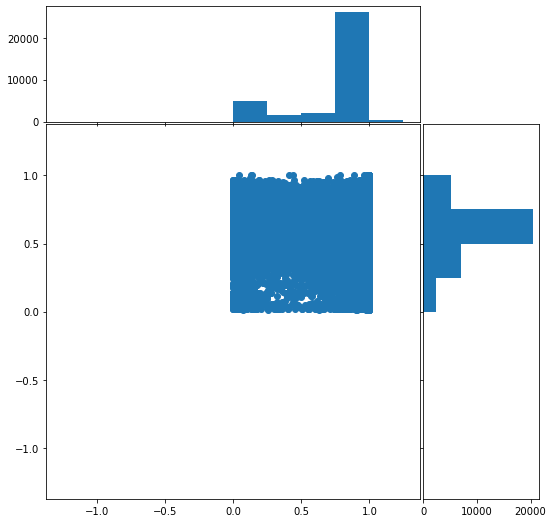

In [353]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(bert_conf_of_correct_class, valence, ax, ax_histx, ax_histy)

plt.show()

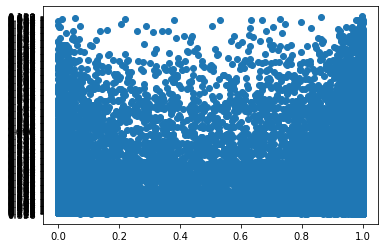

In [342]:
plt.scatter(bert_conf_of_correct_class, valence)

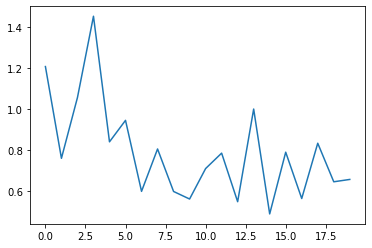

In [299]:
import matplotlib.pyplot as plt
import numpy as np

#new_acc_list = [it.item() for it in accuracy_list]
plt.plot(val_loss_list)

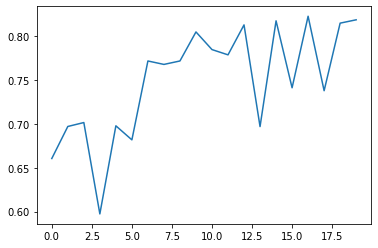

In [300]:
plt.plot(val_acc_list)

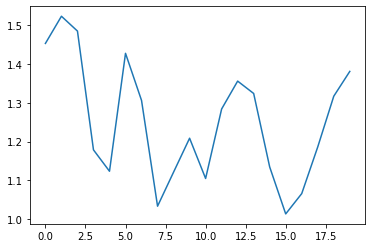

In [59]:
plt.plot(epoch_loss_list)

In [8]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 5.6 MB/s eta 0:00:01


In [9]:
import torchmetrics

/opt/conda/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/tf14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [16]:
import torch
preds = torch.tensor([0.3600, 0.8])
target = torch.tensor([0, 0])
torchmetrics.functional.accuracy(preds, target, threshold=0.5)

tensor(0.5000)